# Hands-on Notebook for WQRN3 Tutorial: ゼロから作る量子ネットワーク


このノートブックは、慶應義塾大学のNaphan Benchasattabuse (whit3z)、Ryosuke Satoh (cocori)、Rodney Van Meterによって書かれました。

このノートブックは [Creative Commons Attribution license (CC BY 4.0 license)](https://creativecommons.org/licenses/by/4.0/)　の下でライセンスされています。



# Jupyterノートブックの使い方

Jupyterノートブックにはコードセルとテキストセルの2種類のセルがあります。

コードセルではコードを書いて実行することができます（ここではPython）。コードを実行するためには、ランタイムもしくはカーネルを起動する必要があります。通常、ランタイムは自動的に起動します。書かれたコードはランタイムによって実行され、変数が保存されます。一度保存された変数は、たとえセルを消したとしても残り続けていることに気をつけてください。すべての変数を消して最初の状態にしたいときは、ランタイムを再起動してください。各セルは、どのような順序でも実行することができます。したがって、わざとノートブックに書かれた順番通りに実行しなかった場合、エラーや意図しない挙動をすることがあります。

テキストセルは、コードセルに対するコメントやドキュメンテーションとして使われます。また今あなたが読んでいるこのセルのように、ノートブックを通してあなたの考えを導くためのメモや説明として使うこともできます。

### ノートブックの歩き方

- `shift + enter` でコードセルの内容を実行したり、テキストセルを描画してから、次のセルにフォーカスすることができます。
- `print()` コマンドがない場合、コードセルの最後の行の出力が表示されます。

### 基本的なトラブルシューティング

- もしコードセルを実行してエラーが出た場合、その前のセルで宣言されている変数にアクセスしようとしているか確認してください。もしそうであれば、その前のセルがすでに実行されているか確認してください。

### 下にある最初のセルを実行してみましょう

コードセルは、そのセルの前にある `[ ]`　にマウスをホバーさせたときに表示される "再生" アイコンをクリックすることで実行できます。コードセルを実行後、カッコの中に数字が表示されます。この数字は、これまで何個のセルを実行したかを表しています。もしこれが、あなたが新たに起動したランタイムであれば、`[1]` と表示されるはずです。

次のセルの出力は `5` となるはずです。

In [ ]:
## 数字を足してみましょう
2 + 3


### 必要なライブラリをインストールするために、下のセルを実行してください

量子コンピューティングをシミュレートし、出力統計を可視化するために、[Qiskit](https://qiskit.org/documentation/locale/ja_JP/tutorials/circuits/1_getting_started_with_qiskit.html)を使用します。

In [47]:
!pip install qiskit
!pip install qiskit-aer
!pip install 'qiskit[visualization]'
!pip install pylatexenc

Template code and some helper functions

In [ ]:
# 必要なライブラリをインポートします
import numpy as np

from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace
from IPython.display import Javascript

# 量子回路を可視化するためにシミュレーターを初期化します
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# mplを量子回路の可視化にデフォルトで使用します
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')


In [ ]:
# スタンドアローンのノートブックでも動作させるためのヘルパー関数(modified by whit3z)
def show_info(qc, use_statevector_only=False):
    """この関数は、quantum circuitオブジェクトを受け取り、counts / statevectorを出力します"""
    qc_remove_measurement = qc.remove_final_measurements(inplace=False)
    counts = qasm_sim.run(qc, shots=10000).result().get_counts()
    statevector = sv_sim.run(qc_remove_measurement).result().get_statevector()
    print('====== state_vector ======')
    display(statevector.draw(output='latex'))
    print('')
    print('====== true probability distribution =====')
    display(plot_histogram({k: np.abs(v) ** 2 for k, v in statevector.to_dict().items()}, title='true probability distribution', color='midnightblue'))
    print('====== counts from measurements ======')
    display(plot_histogram(counts, title='readout results histogram'))

def show_info_partial(qc, qubit_list, use_statevector_only=False):
    pass

original_draw = None
if not original_draw:
    original_draw = QuantumCircuit.draw
    def draw(self):
        display(original_draw(self))
    QuantumCircuit.draw = draw

カスタムLaTeXコマンドを作ります

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$


# 量子ゲートの基本 (ユニタリー演算)


---

量子計算における基本操作は、古典的な低レベルのビット列処理のようなビット単位の演算（例えば、and、or、not、xorなど）ではありません。

量子状態はヒルベルト空間上の単位ベクトルとして定義されているため、線形代数のように、ベクトル上で作用する演算は、行列（線形作用素）として定義できます。演算後の新しい状態ベクトルは、有効な状態ベクトルであってほしく、この制約を保つために、その演算子（あるいは行列）はユニタリーである必要があります。


## 量子回路を定義する

量子計算の回路モデルにおいて、まずはじめに量子回路を定義しなければ、状態を定義することができません。

Qiskitでは、下のセルの例のように量子回路を定義することができます。

量子回路を定義するには、2つの主な方法があります。

1. 簡単な記法 `QuantumCircuit(<#qubit>, <#classical_bit>)` を使って回路を定義し、そのあとで回路中の量子ビットに添字（インデックス）でアクセスする方法
2. 最初にレジスターを定義して、それらを使って量子回路を初期化する方法

レジスターに名前を付ける二つ目の方法は、複数の量子ビットを取り扱い、それらを用途に応じて分けて使う場合に便利です。あとで量子テレポーテーションを扱う時にわかりやすくするために、この方法を使います。

In [ ]:
# シンプルな1量子ビットの量子回路を作ります

# 簡単な記法
shorthand_circuit = QuantumCircuit(1, 1) # 1量子ビット, 読み出しのための古典の1bit

# レジスタから組み立てる方法
q_reg = QuantumRegister(1, 'qreg')
c_reg = ClassicalRegister(1, 'creg')
qc = QuantumCircuit(q_reg, c_reg)

### Exercise: あなたの量子回路を定義しましょう

上に示した方法を用いて、新しい量子回路を作ってみましょう。二つ以上の量子レジスタを含む回路を作ってください。

In [48]:
"""Exercise: Try creating circuits here"""
Qbit_circuit = QuantumCircuit(2, 2)

## 量子ゲートを適用する

では、いくつかの単一量子ビットゲートをみてみましょう。

Identityゲート (何もしないゲート)

$I=\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]$

3つのパウリ行列 (パウリゲート)

$
X=\sigma_{x}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right], \\
Y=\sigma_{y}=\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right], \\
Z=\sigma_{z}=\left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] .
$

パウリXは、古典におけるNOTゲートに相当するゲートです。

アダマールゲート(Hadamard gate, H)は、重ね合わせを作るためによく使われます。

$H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]$

`qc.h(<qubit_index>)` を使って、$ H \ket{0}$ から $\ket{0}$ と $\ket{1}$ の間の重ね合わせ状態を作り出すためには、

In [ ]:
# 一様な重ね合わせを作成

qc = QuantumCircuit(1, 1)
qc.h(0)

その他のゲートも同じように呼ぶことかできます。

`QuantumCircuit.x()` `QuantumCircuit.y()` `QuantumCircuit.z()`

[RY gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYGate.html)のような、一様ではない重ね合わせを定義するための便利なゲートがあります。これは、RY gateは角度を調整できるPauli Y演算子です。

$RY(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\ \sin \frac{\theta}{2} & \cos \frac{\theta}{2}\end{array}\right)$

同様に [Rx](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) と [Rz](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html) もあります。


Note: Qiskitで定義されている他のゲートは[ここ](https://qiskit.org/documentation/apidoc/circuit_library.html)で確認できます。

## 量子回路の描画

量子回路を描画するには、`.draw()` コマンドを使います。

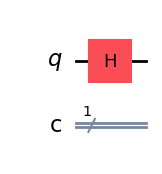

In [49]:
# 初期化
qc = QuantumCircuit(1, 1)
qc.h(0)

# 描画
qc.draw()

### Exercise: 量子回路を作って描画する

2量子ビットの回路を作ってみてください。1つ目の量子ビットにXをかけてから、Zをかけます。そして2つ目の量子ビットにはHをかけます。

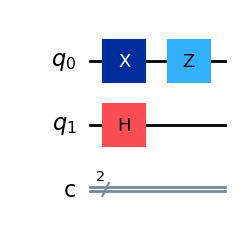

In [39]:
""" Exercise: Fill in your code here """
qc = QuantumCircuit(2, 2)
qc.x(0)
qc.z(0)
qc.h(1)
qc.draw()

## 量子ビットの測定によって回路から情報を得る

量子システムや量子状態から有益な情報を得るためには、量子状態に対して測定を行う必要があります。私たちが得られる、注目に値する情報は **古典的情報です**

測定は、`QuantumCircuit.measure(<qubit>, <classical_bit>)` を呼び出すことでQiskitの中で行われます。ここまで私たちは回路中に古典ビットを定義していましたが、使っていませんでした。ここでは、なぜ古典ビットが必要だったかをみていきます。

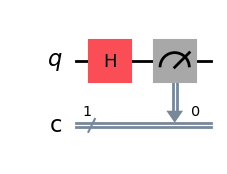

In [38]:
# 初期化
qc = QuantumCircuit(1, 1)
qc.h(0)

# 測定を追加します
qc.measure(0, 0)
qc.draw()

最後に計測が行われるような回路を渡されると、読み出された分布（このヘルパー関数は1万ショットで回路を走らせる）と、最終計測の直前の状態ベクトル出力を出力するヘルパー関数があります。これは、`show_info(qc)` で呼び出すことができます。

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


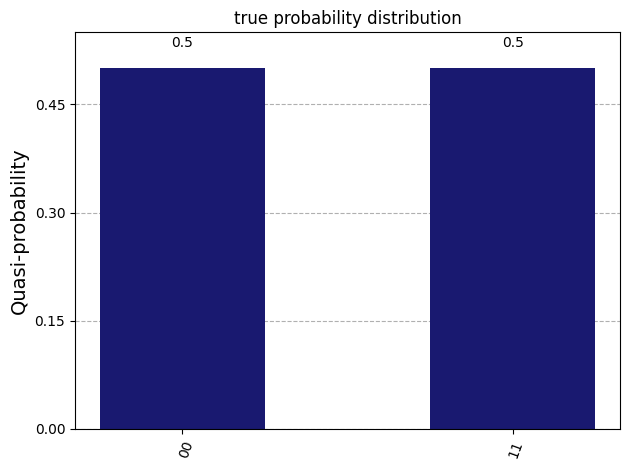

====== counts from measurements ======


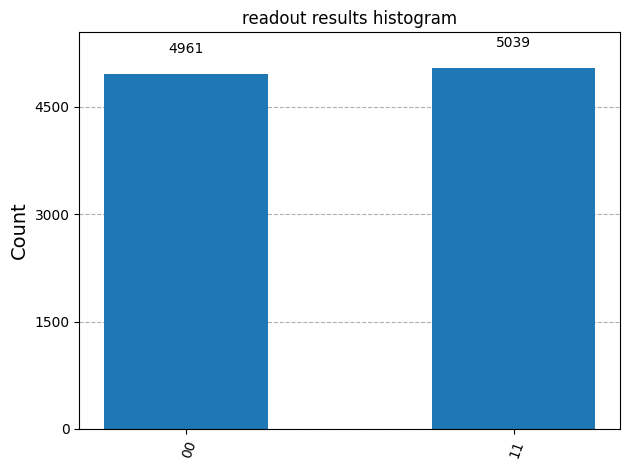

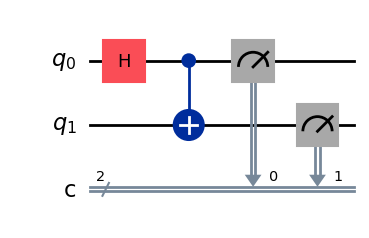

In [37]:
# show_info(qc)

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])
show_info(qc)
qc.draw()

### ketのエンディアンと回路図における表記

ある複数の量子ビットを含む回路は下の図のようになります

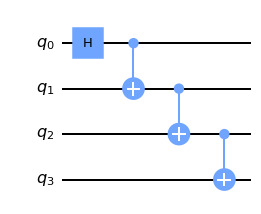

この場合、回路中の上から下に並ぶ量子ビットを、それぞれ左から右へ書くと、状態ベクトルは $\ket{q_0, q_1, q_2, q_3}$ と書けるでしょう（ビッグエンディアン記法）。

しかし、計算機科学におけるビット列や2進数の記法にしたがって上位ビット（most significant bit MSB)を左側に置くリトルエンディアン記法を用いた場合、状態ベクトルは $\ket{q_3, q_2, q_1, q_0}$ と書けるでしょう。

Qiskitはデフォルトで $q_0$ を一番上に描画し、レジスタに最後に書き込むようになっています。

エンディアンについて詳しくは [wikipedia page](https://ja.wikipedia.org/wiki/%E3%82%A8%E3%83%B3%E3%83%87%E3%82%A3%E3%82%A2%E3%83%B3)

記法について詳しくは [Qiskit textbook](https://qiskit.org/textbook/ja/ch-states/representing-qubit-states.html)

# 量子もつれとベル状態

---

2量子ビットの最大エンタングル状態あるいはベルペアが、S値(CHSH不等式)が $2\sqrt{2}$ となる4つの異なる形式をもつことを思い出してください。

$\begin{aligned}
\left|\Phi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)
\\
\left|\Phi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)
\\
\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle)
\\
\left|\Psi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)
\end{aligned}$

## ベル状態をの生成

最もよく知られたベルペアの形は $\Phi^+$ です。この状態は、次のコードで作ることができます。

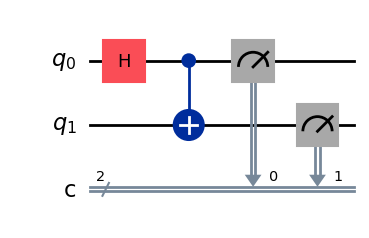

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


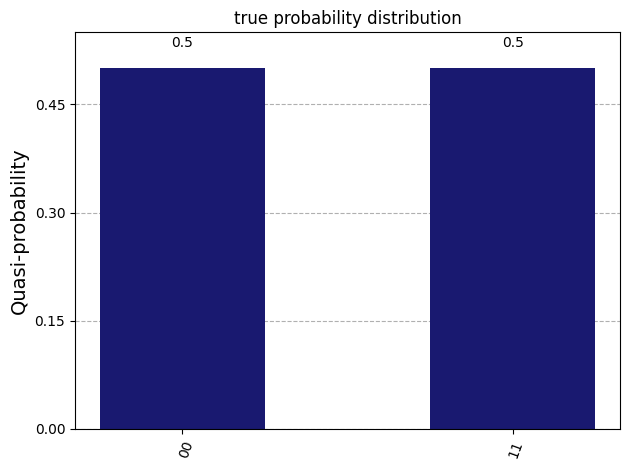

====== counts from measurements ======


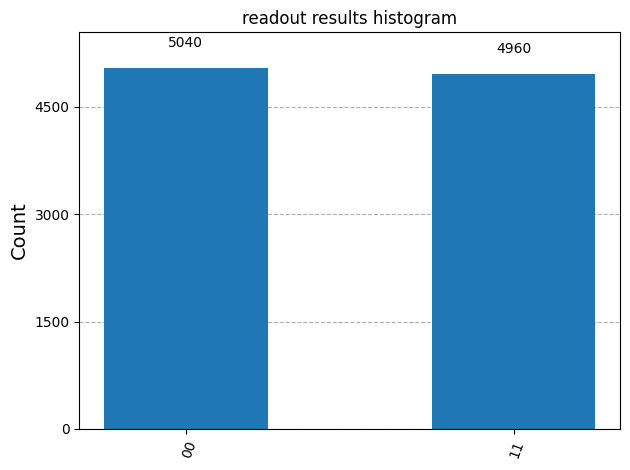

In [36]:
# phi+ の回路

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0,1], [0, 1])

# 回路とその出力を表示します
qc.draw()
show_info(qc)

### 2量子ビットゲート(CNOTゲート)

上の回路には、初めて出てくるゲート、CNOTがあります。

CNOTあるいはCXゲートは、次の行列で定義されます。

$\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]$

この行列では、量子ビットの順序はQiskitの表記法に従っています。

一般的な教科書などでは、次のようにビッグエンディアンで書かれているでしょう。

$\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right]$

2量子ビットゲートがなければ、量子力学の奇妙さの基本であり、古典コンピューティングに対する優位性の肝となる量子もつれを作ることができません。

### 量子回路の合成

これまで、私たちは毎回新しい変数を用意し、そこへQiskitにある基本的なゲートをかけて、新たな量子回路を作ってきました。

小さな部品を作ってから、それらを組み合わせてより大きな量子回路を作ろうとしたときに、今までのやり方はよくありません。

あとで使うための量子回路を定義し、それらを組み合わせて使う方法を下のコードに示します。
それでは、$\Phi_+$ 状態を作成する例をみてみましょう。

phi plus circ


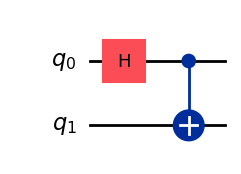

two qubit measurement circ


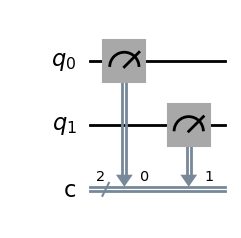

the composed circuit


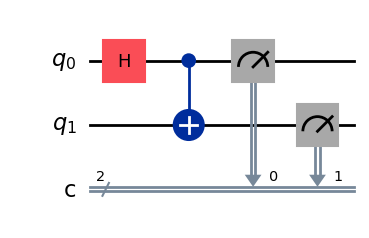

In [18]:
def phi_plus_prep():
    # Phi+ を作成する回路

    phi_plus_circ = QuantumCircuit(2)
    phi_plus_circ.h(0)
    phi_plus_circ.cx(0, 1)
    return phi_plus_circ

def two_qubit_measurement_circuit():
    # 2量子ビットを測定するための回路
    two_qubit_measurement_circ = QuantumCircuit(2, 2)
    two_qubit_measurement_circ.measure([0, 1], [0, 1])
    return two_qubit_measurement_circ

# 二つの回路をそれぞれ分けて表示する
print('phi plus circ')
phi_plus_prep().draw()
print('two qubit measurement circ')
two_qubit_measurement_circuit().draw()


# 二つの回路を組み合わせて一つの回路にする
## まずはじめに、新たな回路を用意する

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_plus_prep())
qc = qc.compose(two_qubit_measurement_circuit())
print('the composed circuit')
qc.draw()

### Exercise: $\Phi^-$ 状態を作成する

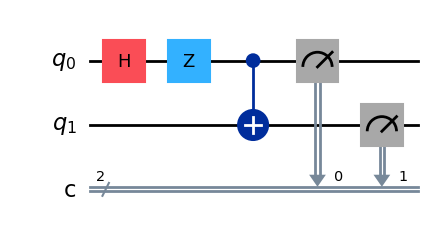

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


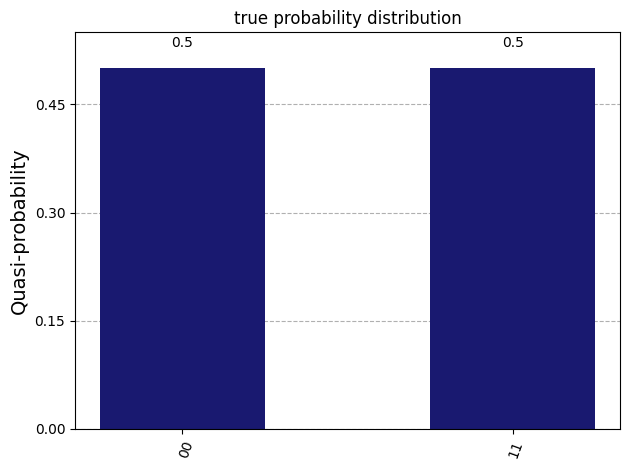

====== counts from measurements ======


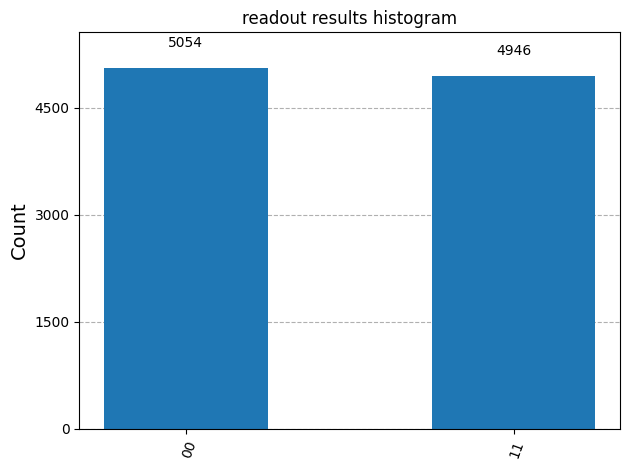

In [11]:
# Phi- の作成

def phi_minus_prep():
  phi_minus_circ = QuantumCircuit(2)

  """Complete the code"""
  phi_minus_circ.h(0)
  phi_minus_circ.z(0)
  phi_minus_circ.cx(0,1)
  return phi_minus_circ

def two_qubit_measurement_circuit():
  two_qubit_measurement_circ = QuantumCircuit(2, 2)
  two_qubit_measurement_circ.measure([0,1],[0,1])
  return two_qubit_measurement_circ

  """End"""
  return phi_minus_circ

# 測定結果と量子回路を表示します
qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_minus_prep()).compose(two_qubit_measurement_circuit())
qc.draw()
show_info(qc)

### Exercise: $\Psi^+$ 状態を作成する

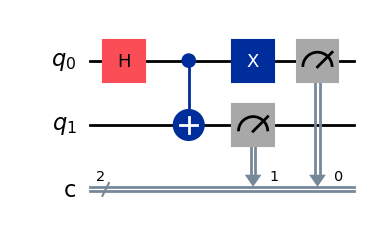

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


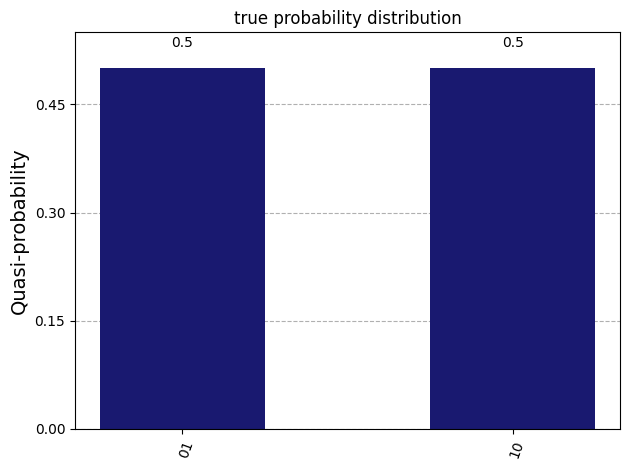

====== counts from measurements ======


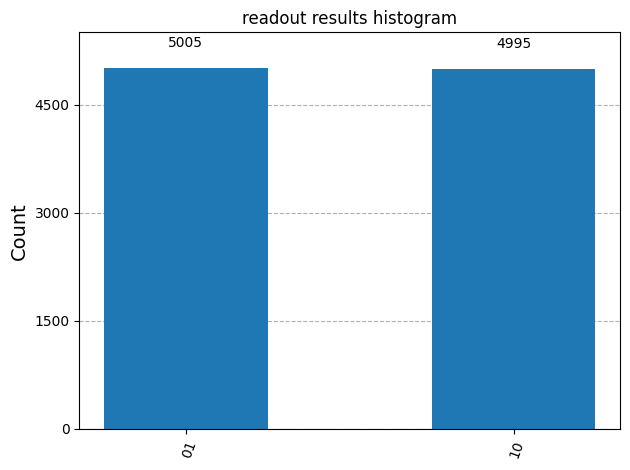

In [12]:
# Psi+ の作成

def psi_plus_prep():
  psi_plus_circ = QuantumCircuit(2)

  """Complete the code"""
  psi_plus_circ.h(0)
  psi_plus_circ.cx(0,1)
  psi_plus_circ.x(0)
  return psi_plus_circ

def two_qubit_measurement_circuit():
  two_qubit_measurement_circ = QuantumCircuit(2, 2)
  two_qubit_measurement_circ.measure([0,1],[0,1])
  return two_qubit_measurement_circ
  """End"""
  return psi_plus_circ

# 測定結果と量子回路を表示します
qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_plus_prep()).compose(two_qubit_measurement_circuit())
qc.draw()
show_info(qc)

### Exercise: $\Psi^-$ 状態を作成する

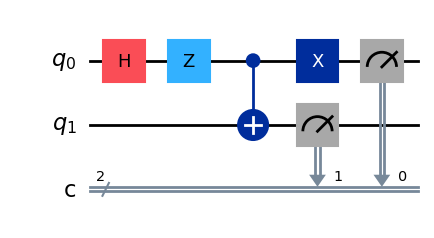

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


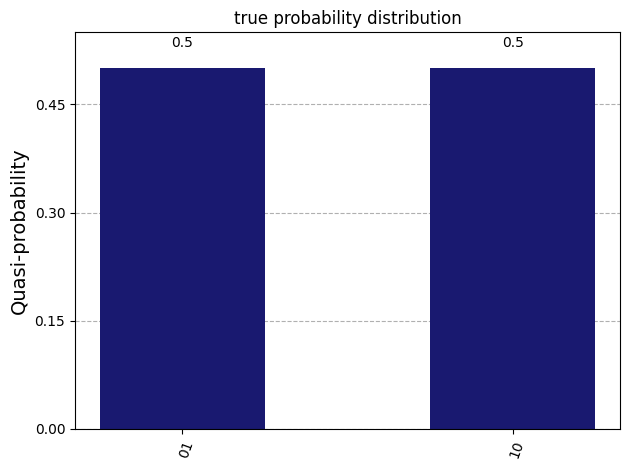

====== counts from measurements ======


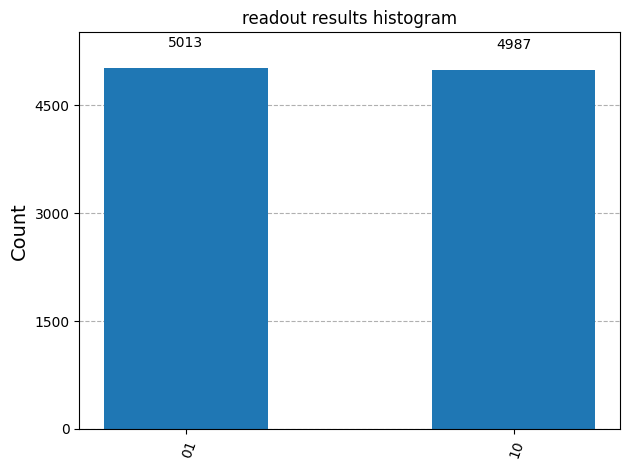

In [13]:
# Psi- の作成

def psi_minus_prep():
    psi_minus_circ = QuantumCircuit(2)

    """Complete the code"""
    psi_minus_circ.h(0)
    psi_minus_circ.z(0)
    psi_minus_circ.cx(0,1)
    psi_minus_circ.x(0)
    return psi_minus_circ

def two_qubit_measurement_circuit():
    two_qubit_measurement_circ = QuantumCircuit(2, 2)
    two_qubit_measurement_circ.measure([0,1],[0,1])
    return two_qubit_measurement_circ
    """End"""
    return psi_minus_circ

# 測定結果と量子回路を表示します
qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_minus_prep()).compose(two_qubit_measurement_circuit())
qc.draw()
show_info(qc)

## ベル状態測定器 (Bell State Analyzer)
---

仮にベルペアがあるとして、しかしそのベルペアが4つの取り得る状態のうちどれかわからないとき、**ベル測定**（レッスン13のステップ2の動画で学びました）と呼ばれる特殊な測定を行うことで、どの状態かを特定することができます。Qiskitでは測定がZ基底（計算基底）で行われることを思い出してください。私たちの仕事は、ベル基底をZ基底に変えるユニタリーを実装することです。


つまり、それぞれの形を下の表のようなベル状態で読み替えるということです。

| Bell state                          |   q0,q1 (eigenvalues) | output from the circuit |
|---------                            |--------------         | -------------           |
| $\left\vert\Phi^{+}\right\rangle$   | +1,+1                 | 00                      |
| $\left\vert\Phi^{-}\right\rangle$   | +1,-1                 | 01                      |
| $\left\vert\Psi^{+}\right\rangle$   | -1,+1                 | 10                      |
| $\left\vert\Psi^{-}\right\rangle$   | -1,-1                 | 11                      |


**上の表は有効な対応関係の一つであり、4つのベル状態から4つの計算基底への1対1の対応関係はどれも同じように機能します。**

### 追記

もしあなたが線形代数に慣れ親しんでいれば、実装しなければならないそのユニタリーは基底の変換行列と同じものであることを思い出したかもしれません。
この素晴らしい[動画](https://youtu.be/P2LTAUO1TdA)では、基底の変換についてより詳しく知ることができます。

### Exercise: BSA回路を作成する
Note: 測定をこのBSAコンポーネントに追加しないでください。測定は、あとで別のコンポーネントに追加します。

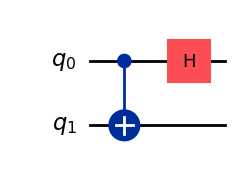

In [16]:
def bell_state_analyser():

    bell_state_analyser_circuit = QuantumCircuit(2)

    """Complete the code"""
    bell_state_analyser_circuit.cx(0,1)
    bell_state_analyser_circuit.h(0)
    """End"""
    return bell_state_analyser_circuit.remove_final_measurements(inplace=False)

bell_state_analyser().draw()

### 作成したBSA回路をテストする

それでは、作成したBSA回路が期待した通りに動くかどうか試してみましょう。この回路は、上のテーブルと同じ測定結果を出力するはずです。
**この下にある4つのコードセルは、変更する必要がありません。**

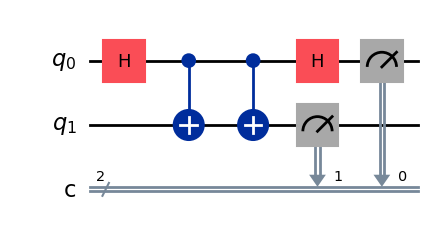

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


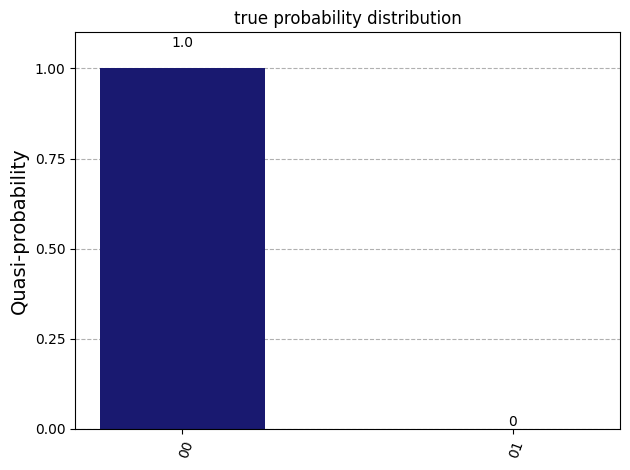

====== counts from measurements ======


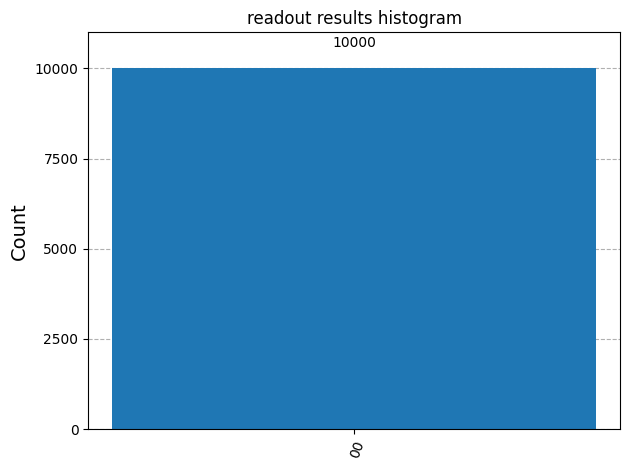

In [19]:
## Phi+をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_plus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

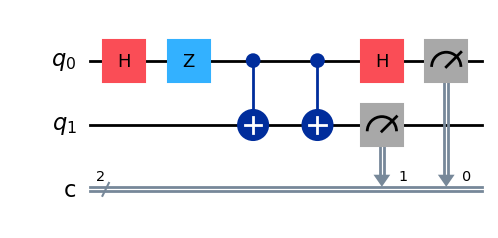

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


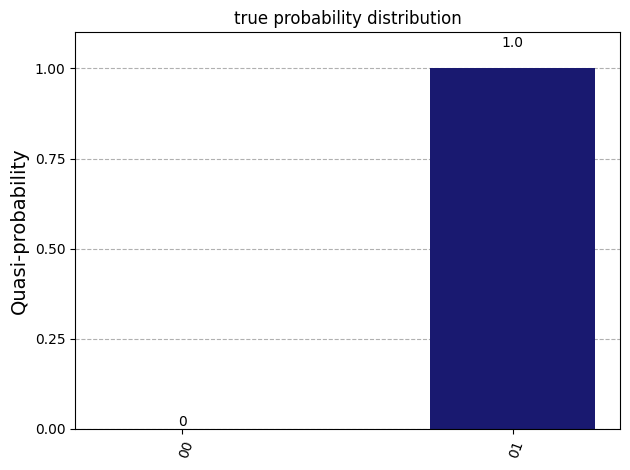

====== counts from measurements ======


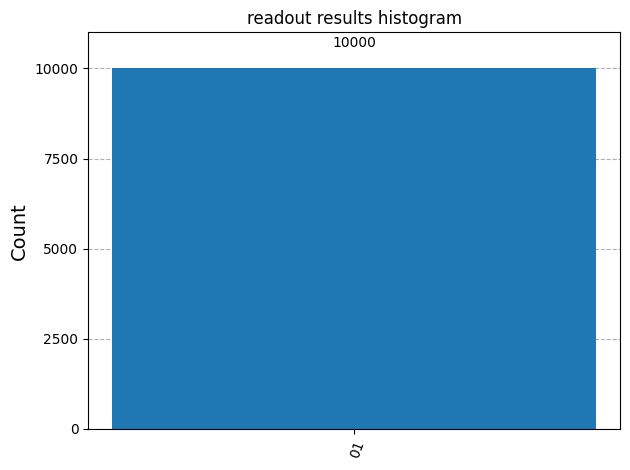

In [20]:
## Phi-をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_minus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

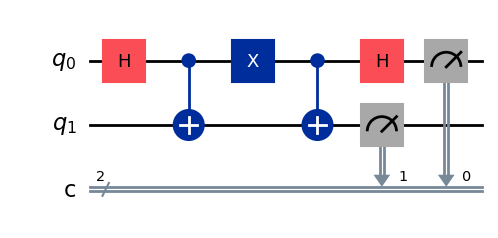

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


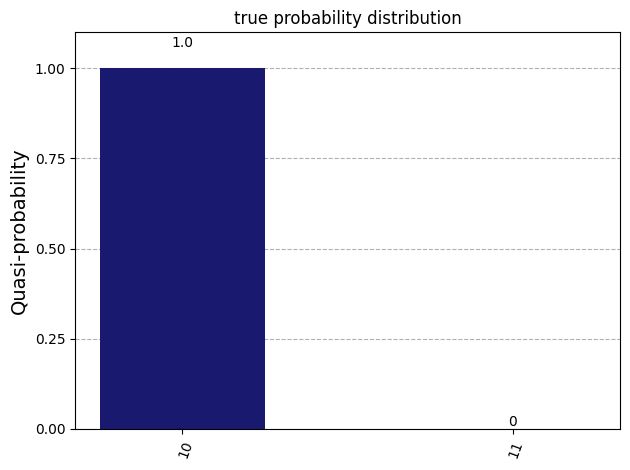

====== counts from measurements ======


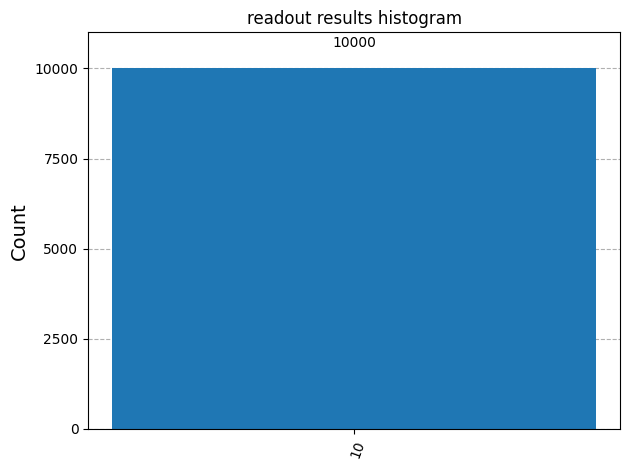

In [21]:
## Psi+をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_plus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

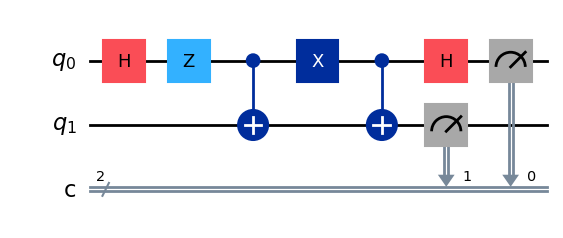

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


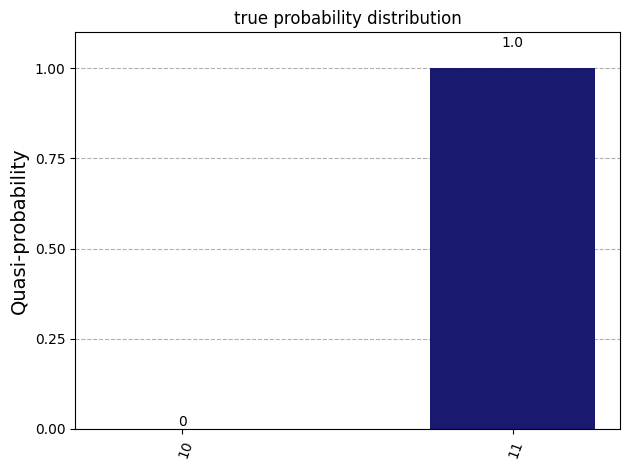

====== counts from measurements ======


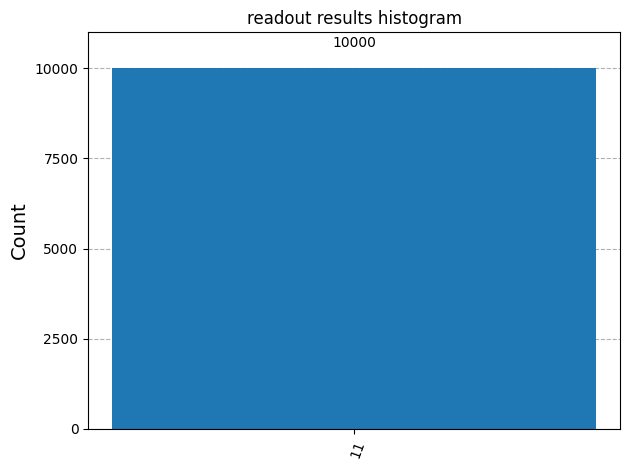

In [22]:
## Psi-をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_minus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

**ベル状態の違いを見分けるための4つの回路の出力は正しいでしょうか？**

# 量子テレポーテーション

---

ある物体を別の場所へ一瞬で移動させる、テレポートというものを聞いたことがあるでしょう。幸か不幸か、量子テレポーテーションは一瞬で起こるものではありませんし、物体ではなく量子データを移動させる現象です。さらに、移動というのも厳密には違います。量子テレポーテーションは一つのベルペアを消費して、ある量子状態を**破壊**し、同じ量子状態を違う場所で**再生成**します。これは、光速を超える通信を実現**できません**が、その理由は後ほど説明します。

AliceとBobがいるとします。AliceとBobはすでにベルペアを作って共有しています。Aliceは、Bobに送りたいデータ量子ビット（量子状態）を持っているとします。まず、Aliceは既に作ったBSA回路を使って、彼女の持っているデータ量子ビットと彼女持っているベルペアの半分を担う量子ビットに対してベル測定を行います。Aliceが測定を行なった後、彼女はその結果をなんらかの方法でBobに送ります。BobはAlice側でのタスクが終わったことを知ったら、その情報を用いて、すでに破壊されたベルペアのうちBob側の量子ビットに対してある操作（パウリ訂正、もしくは訂正フレーム）を行います。この操作によって、最初にAliceのデータ量子ビットにあった量子状態は、Bobの量子ビットに出現します。これが量子テレポーテーションの一連の流れとなります。

それでは、各ステップごとに何が起きていたのかを分析してみましょう。

1. AliceとBobはベルペアを共有していなければいけません（この例では、$\Phi_+$ 状態とします）
1. Aliceはデータ量子ビットを用意します $\ket{\Psi} = \alpha \ket{0} + \beta \ket{1}$
1. Aliceはベルペアの片方とデータ量子ビットに対してベル測定を行います。

<!-- Let's pause here for a bit and write the states out and for simplicity of writing we will drop the $1 / \sqrt{2}$ in factor of the Bell state

$\begin{aligned}
\ket{0_A 0_B} + \ket{1_A 1_B}
\\
\ket{\Psi} \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
( \alpha \ket{0_{A'}} + \beta \ket{1_{A'}} ) \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
( \alpha \ket{0_{A'}} + \beta \ket{1_{A'}} ) \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
\alpha \ket{0_{A'}} \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right) + \beta \ket{1_{A'}}\otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
\alpha \ket{0_{A'} 0_A 0_B} + \alpha \ket{0_{A'} 1_A 1_B} + \beta \ket{1_{A'} 0_A 0_B} + \beta \ket{1_{A'} 1_A 1_B}
\end{aligned}$ -->

ここで少し立ち止まって、全ての初期状態を書き出してみましょう。

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B} &=(\alpha|0\rangle+\beta|1\rangle)_{A_{1}} \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)_{A_{2} B} \\ &=\frac{1}{\sqrt{2}}(\alpha|000\rangle+\alpha|011\rangle+\beta|100\rangle+\beta|111\rangle)_{A_{1} A_{2} B} \end{aligned}$

4つのベル状態を計算基底で書き出すと次のように書けることを私たちは既に知っています。

$\left|\Phi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \quad\left|\Phi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)$
$\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle) \quad\left|\Psi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)$

あるいは、計算基底で書かれた状態を、ベル基底では次のように書けます。

$\begin{array}{ll}|00\rangle=\frac{1}{\sqrt{2}}\left(\left|\Phi^{+}\right\rangle+\left|\Phi^{-}\right\rangle\right) & |01\rangle=\frac{1}{\sqrt{2}}\left(\left|\Psi^{+}\right\rangle+\left|\Psi^{-}\right\rangle\right) \\ |10\rangle=\frac{1}{\sqrt{2}}\left(\left|\Psi^{+}\right\rangle-\left|\Psi^{-}\right\rangle\right) & |11\rangle=\frac{1}{\sqrt{2}}\left(\left|\Phi^{+}\right\rangle-\left|\Phi^{-}\right\rangle\right)\end{array}$

Using above trick, we can rewrite the states as
これらのテクニックを使って、冒頭にとりあげた初期状態を書き直してみると、

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B}=&(\alpha|0\rangle+\beta|1\rangle)_{A_{1}} \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)_{A_{2} B} \\=& \frac{1}{\sqrt{2}}(\alpha|000\rangle+\alpha|011\rangle+\beta|100\rangle+\beta|111\rangle)_{A_{1} A_{2} B} \\=& \frac{1}{\sqrt{2}}\left(\alpha\left(\left|\Phi^{+}\right\rangle+\left|\Phi^{-}\right\rangle\right)|0\rangle\right.\\ &+\alpha\left(\left|\Psi^{+}\right\rangle+\left|\Psi^{-}\right\rangle\right)|1\rangle \\ &+\beta\left(\left|\Psi^{+}\right\rangle-\left|\Psi^{-}\right\rangle\right)|0\rangle \\ &+\beta\left(\left|\Phi^{+}\right\rangle-\left|\Phi^{-}\right\rangle\right)|1\rangle \end{aligned}$

そして、いくつかの項を括り直して整理してみると、次のような結果を得ます。

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B} &=\frac{1}{2}\left|\Phi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle+\beta|1\rangle)_{B} \\ &+\frac{1}{2}\left|\Phi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle-\beta|1\rangle)_{B} \\ &+\frac{1}{2}\left|\Psi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle+\beta|0\rangle)_{B} \\ &+\frac{1}{2}\left|\Psi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle-\beta|0\rangle)_{B} \end{aligned}$

したがって、4つのベル基底状態の出力は同様に確からしいことがわかります。そして、Aliceがどの測定結果を得たかによって、Bobのもっている状態は、ビットか位相、あるいはその両方が反転していることがわかります。

ここで、私たちは状態に対してなにもしていないことに気を付けてください。ただ、初期状態の項を書き直して、括り直しただけなのです！

## 量子テレポーテーションは一瞬で起きるか？

Bobがひとつの量子ビットを持っているとします。彼ら視点からみるとその状態は、

$\left|\Phi^{+}\right\rangle_{A_{2} B}=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \longrightarrow \rho_{B}=\frac{1}{2}|0\rangle\left\langle 0\left|+\frac{1}{2}\right| 1\right\rangle\langle 1|$

これは最大混合状態です。

Aliceが測定する前の状態は、

$\frac{1}{2}\left|\Phi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle+\beta|1\rangle)_{B}+\frac{1}{2}\left|\Phi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle-\beta|1\rangle)_{B}$
$+\frac{1}{2}\left|\Psi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle+\beta|0\rangle)_{B}+\frac{1}{2}\left|\Psi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle-\beta|0\rangle)_{B}$

では、Aliceが測定した直後のBobの状態はどうなっているでしょうか？

$\operatorname{Prob}\left(\left|\Phi^{+}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|0\rangle+\beta|1\rangle$
$\operatorname{Prob}\left(\left|\Phi^{-}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|0\rangle-\beta|1\rangle$
$\operatorname{Prob}\left(\left|\Psi^{+}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|1\rangle+\beta|0\rangle$
$\operatorname{Prob}\left(\left|\Psi^{-}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|1\rangle-\beta|0\rangle$

では、Bobの視点からみた彼の量子ビットの状態はどうでしょうか？

$\begin{aligned} \rho_{B} &=\frac{1}{4}(\alpha|0\rangle+\beta|1\rangle)\left(\alpha^{*}\langle 0|+\beta^{*}\langle 1|\right) \\ &+\frac{1}{4}(\alpha|0\rangle-\beta|1\rangle)\left(\alpha^{*}\langle 0|-\beta^{*}\langle 1|\right) \\ &+\frac{1}{4}(\alpha|1\rangle+\beta|0\rangle)\left(\alpha^{*}\langle 1|+\beta^{*}\langle 0|\right) \\ &+\frac{1}{4}(\alpha|1\rangle-\beta|0\rangle)\left(\alpha^{*}\langle 1|-\beta^{*}\langle 0|\right) \end{aligned}$

そして、

$\begin{aligned} \rho_{B} &=\frac{1}{2}\left(|\alpha|^{2}+|\beta|^{2}\right)|0\rangle\langle 0| \\ &+\frac{1}{2}\left(|\alpha|^{2}+|\beta|^{2}\right)|1\rangle\langle 1| \\ &=\frac{1}{2}|0\rangle\left\langle 0\left|+\frac{1}{2}\right| 1\right\rangle\langle 1| \end{aligned}$

これはまだ、最大混合状態です！

つまり、Aliceが測定をした直後では、まだテレポーテーションは起きていないのです。

アリスが結果を送っても、ボブが最終的に結果を受け取るまで、測定はまだ行われません。その時点でようやくテレポーテーションが行われたと言えるのです。

**このように、パウリ訂正メッセージの速度が光速に制限されるために、光速を超える通信を行うことはできません**

これで、量子テレポーテーションの背後にある理論を我々は理解しました。それでは、量子回路の形にして試してみましょう。

### Exercise: Aliceのデータ量子ビットを初期化する

RYゲートを使って、一様ではないランダムな量子状態を作ってみましょう。
Try and pick $\theta$ you want and we will use this same state for Alice in our teleportation circuit.
好きな $\theta$ を決めましょう。ここで作った状態を、Aliceのデータ量子ビットの状態としてテレポーテーションの回路で使います。

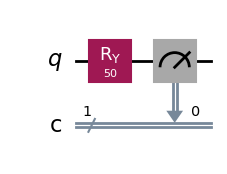

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


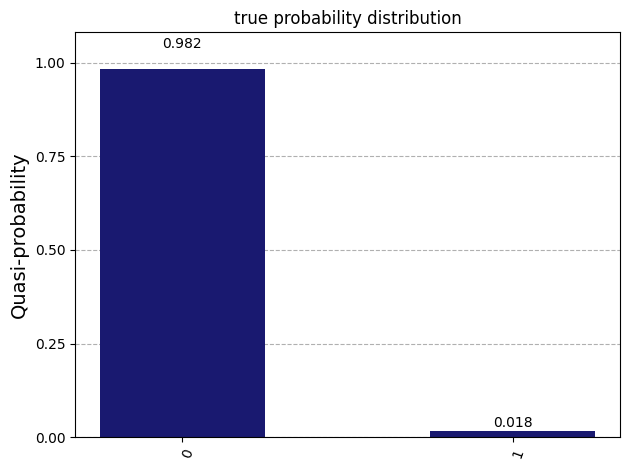

====== counts from measurements ======


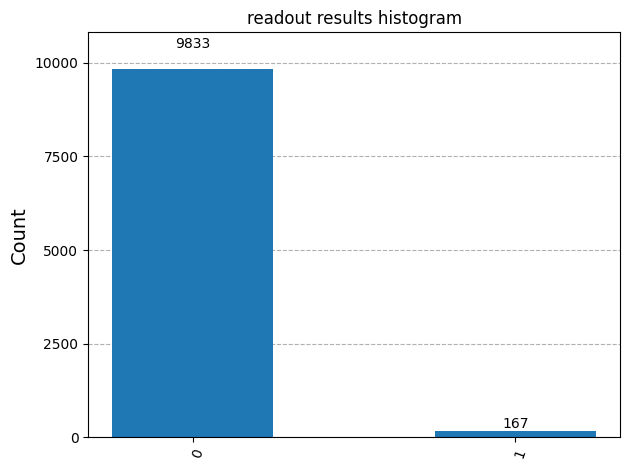

In [23]:
alice_qubit_circ = QuantumCircuit(1, 1)

"""Choose your own theta"""
## Begin
# 好きな値に変えてみましょう！

theta = 50

## End


alice_qubit_circ.ry(theta, 0)
alice_qubit_circ.measure(0, 0)

display(alice_qubit_circ.draw())
show_info(alice_qubit_circ, use_statevector_only=True)

### Exercise: $\theta$ を使ってAliceのデータ量子ビットを初期化する


今回はレジスターに名前をつける方法で回路を作ります。こうすることによって、誰の量子ビットを扱っているかが明確になります。

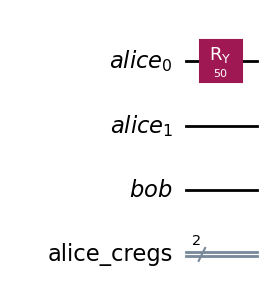

In [25]:
def alice_bob_preparation():
    # AliceとBobのレジスターを作ります
    alice = QuantumRegister(2, "alice")
    bob = QuantumRegister(1, "bob")
    creg = ClassicalRegister(2, "alice_cregs") # この古典レジスタを使って、結果を確認することができます
    return alice, bob, creg, QuantumCircuit(alice, bob, creg)


def prepare_alice_qubit():
    alice, _, _, qc = alice_bob_preparation()
    """Complete the Code below"""
    # 先ほどのシータを再びここで適用します
    # 備忘: もしaliceのデータ量子ビットにxを適用したいのであれば、qc.x(alice[0])によって実現できます
    qc.ry(50,0)
    # qc.ry('theta', 0)
    """End"""
    return qc

prepare_alice_qubit().draw()

### Exercise: AliceとBobの間にベルペアを作成します

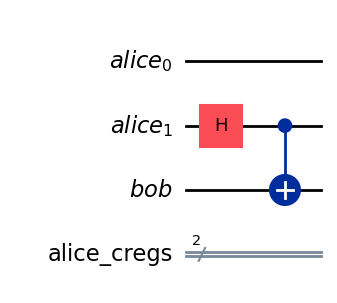

In [26]:
def prepare_bell_pair_between_alice_and_bob():
    alice, bob, _, qc = alice_bob_preparation()
    """Complete the Code below"""
    # qc
    qc.h(alice[1])
    qc.cx(alice[1],bob[0])
    """End"""
    return qc


prepare_bell_pair_between_alice_and_bob().draw()

### Exercise: Aliceの量子ビットに対してベル状態測定を行う

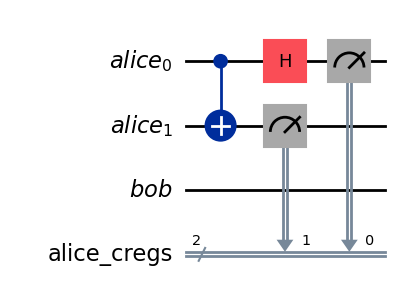

In [28]:
def perform_bsa_on_alice_qubits():
    alice, bob, creg, qc = alice_bob_preparation()
    """Complete the Code below"""
    # 古典レジスタに結果を保存することを忘れずに
    # qc.
    qc.cx(alice[0],alice[1])
    qc.h(alice[0])
    qc.measure(alice[0],creg[0])
    qc.measure(alice[1],creg[1])
    """End"""
    return qc

perform_bsa_on_alice_qubits().draw()

### Exercise: Bobの量子ビットにパウリ訂正を適用する

これまでは、測定は回路の最後にだけ行なってきました。しかし回路の途中で測定を行なって、その古典出力に基づいて次に適用する量子的操作を変えることができます。これは、フィードフォワード操作と呼ばれます。

注意: このフィードフォワード操作は、ほとんどの実機では利用できません。

古典レジスタの値に基づいたゲートを追加するには、`with if_test((<creg_bit>, <creg_value>)):` を使い、そのブロック野中の量子ゲートを記述します。例えば、もしcreg[1]のが1だった場合に、Aliceのデータ量子ビット（qubit 0）にXゲートを適用したい場合は、
`with qc.if_test((creg[1],1)):   
    qc.x(alice[0])`
 と書くことができます。


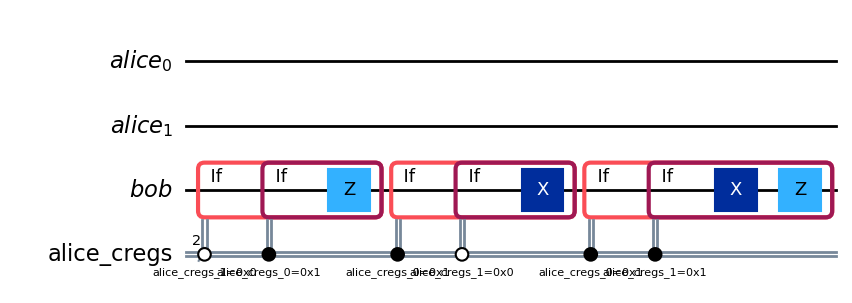

In [57]:
def bob_apply_corrections():
    alice, bob, creg, qc = alice_bob_preparation()
    """Complete the Code below"""
    # BSAの結果を格納するcregインデックスを覚えておき、正しいインデックスに基づいて条件付きゲートを適用する。
    # 例えば、c[2]の結果が1であった場合にq[0]に対してXを実行したい場合、以下のようにして実現することができる:
    # with qc.if_test((c[2], 1)):
    #     qc.x(q[0])
    # phi_minus
    with qc.if_test((creg[1], 0)):
      with qc.if_test((creg[0], 1)):
        qc.z(bob[0])
    #psi_plus
    with qc.if_test((creg[0], 1)):
      with qc.if_test((creg[1], 0)):
        qc.x(bob[0])
    #psi_minus
    with qc.if_test((creg[0], 1)):
      with qc.if_test((creg[1], 1)):
        qc.x(bob[0])
        qc.z(bob[0])
    """End"""
    return qc


bob_apply_corrections().draw()

### 検証の前に、今作った回路の全体像を見てみよう。

各ステップを区切るために、バリア（破線の縦線）が挿入されている。

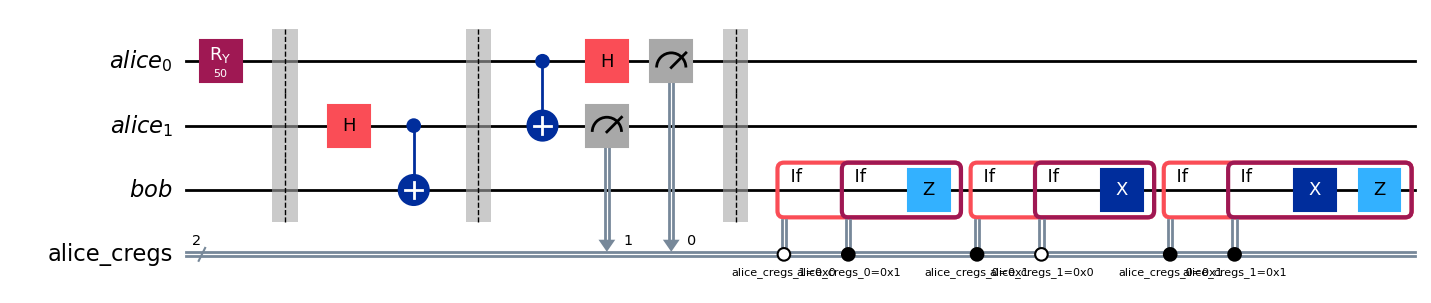

In [58]:
qc = prepare_alice_qubit()
qc.barrier()
qc = qc.compose(prepare_bell_pair_between_alice_and_bob())
qc.barrier()
qc = qc.compose(perform_bsa_on_alice_qubits())
qc.barrier()
qc = qc.compose(bob_apply_corrections())
qc.draw()

### Exercise: 私たちのテレポーテーションが正しいかどうか確認しましょう！

ここまでやってきたことが、すべて正しければ、2つの状態ベクトルのプロットと状態の式が同じになるはずです。
そして、最後に結果を確認するメッセージが表示されます。



alice state vector = Statevector([ 0.99120281+0.j, -0.13235175+0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j],
            dims=(2, 2, 2))
bob state vector = Statevector([ 0.99120281+0.00000000e+00j, -0.13235175+1.62084147e-17j],
            dims=(2,))
Congratulations! You made the teleportation works!


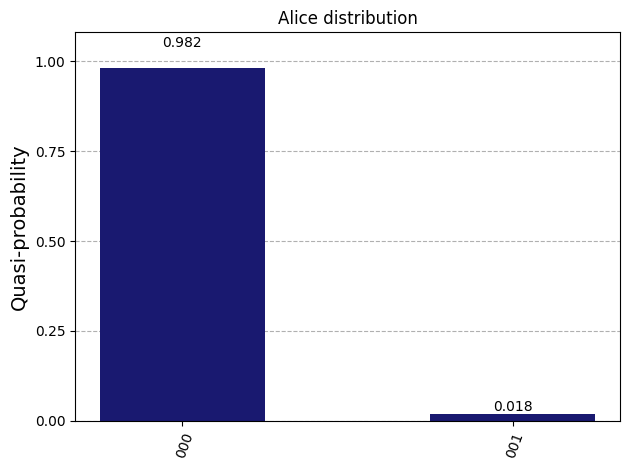

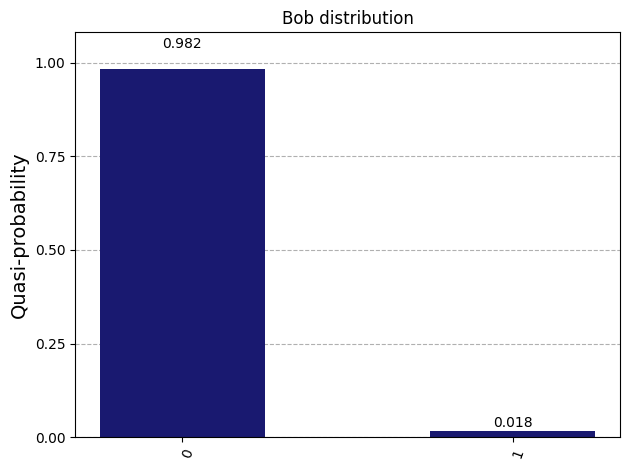

In [59]:
# 状態ベクトル間の等価性をグローバル位相を無視して判定する
alice_data_qubit_sv = sv_sim.run(prepare_alice_qubit().remove_final_measurements(inplace=False)).result().get_statevector()
whole_circuit_sv = sv_sim.run(prepare_alice_qubit()
                              .compose(prepare_bell_pair_between_alice_and_bob())
                              .compose(perform_bsa_on_alice_qubits())
                              .compose(bob_apply_corrections())).result().get_statevector()
alice_initial_qubit_sv = partial_trace(alice_data_qubit_sv, [1, 2]).to_statevector()
bob_final_qubit_sv = partial_trace(whole_circuit_sv, [0, 1]).to_statevector()
print(f'alice state vector = {alice_data_qubit_sv.draw()}')
print(f'bob state vector = {bob_final_qubit_sv.draw()}')
if bob_final_qubit_sv.equiv(alice_initial_qubit_sv):
    print('Congratulations! You made the teleportation works!')
else:
    print('You probably made something wrong!')

display(plot_histogram({k: np.abs(v) ** 2 for k, v in alice_data_qubit_sv.to_dict().items()}, title='Alice distribution', color='midnightblue'))
display(plot_histogram({k: np.abs(v) ** 2 for k, v in bob_final_qubit_sv.to_dict().items()}, title='Bob distribution', color='midnightblue'))

# エンタングルメントスワッピング

---

エンタングルメントスワッピングは、量子ネットワークプロトコルの心臓部分です。これは長距離のベルペアを作るために使われます。

あまり正確ではありませんが、簡単に説明するならば、2組のベルペアの片方を持っている人が、2組のベルペアを繋ぎ合わせることで、より長い一つのベルペアを作る、ということです。


Alice、Bob、Clareの3人がいるとします。


AliceとClareの両者がそれぞれベルペアを作り、それぞれのベルペアの片方の量子ビットをBobに送ります。

次に、Bobがベル状態測定を行い、必要があればAliceとClareが彼女らの量子ビットに対して訂正できるように、Bobは測定の結果を両者へ送ります。


この結果は、AliceとClareの量子ビットに対して、XとZどちらのゲートを適用すべきか選択するために使われます。この操作によって、最初のAliceとClareの量子ビットをもつれさせることができます。

これは、Bobが二つのベルペアを繋ぎ合わせたかのように見えますが、実際のところBobはAlice(Clare)から受け取った量子ビットをClare(Alice)から受け取った量子ビットへと量子テレポーテーションしただけなのです。


### Noted
さらに理解を深めるために、すべての操作、ベル状態の生成、ベル状態測定器をゼロから書いてみましょう。

### Exercise: 次のコードブロックを埋めてみましょう

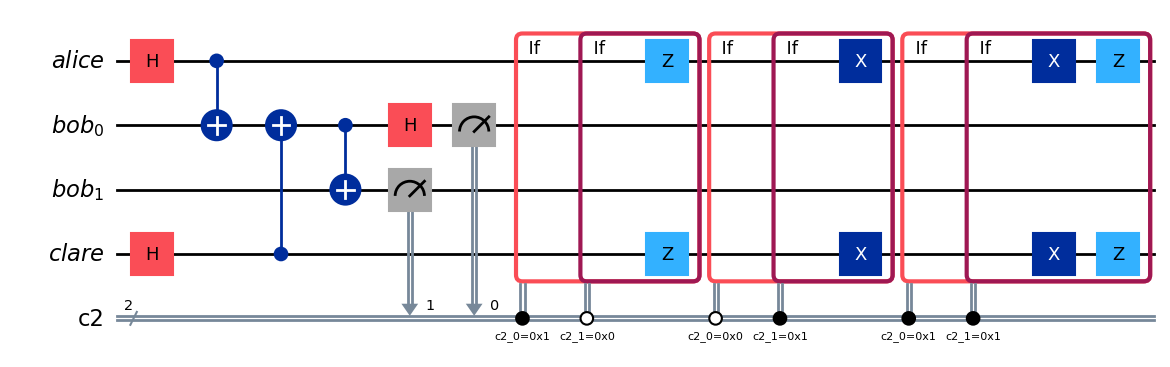

In [63]:
# 初期状態を作ります
def alice_bob_preparation():
    # AliceとBobのレジスターを作ります
    alice = QuantumRegister(1, "alice")
    bob = QuantumRegister(2, "bob")
    clare = QuantumRegister(1, "clare")
    creg = ClassicalRegister(2)  # Bobの測定結果を保存するための古典レジスタ
    qc = QuantumCircuit(alice, bob, clare, creg)
    return alice, bob, clare, creg, QuantumCircuit(alice, bob, clare, creg)


# AliceとBobの間にエンタングルメントを作成する
"""Write your code here"""
def prepare_bell_pair_between_alice_and_bob():
    alice, bob, _, _, qc = alice_bob_preparation()
    qc.h(alice[0])
    qc.cx(alice[0],bob[0])
    return qc

# BobとClareの間にエンタングルメントを作成する
"""Write your code here"""
def prepare_bell_pair_between_bob_and_clare():
    _, bob, clare, _, qc = alice_bob_preparation()
    qc.h(clare[0])
    qc.cx(clare[0],bob[0])
    return qc

# BobがBSAを適用する
"""Write your code here"""
def perform_bsa_on_bob_qubits():
    _, bob, _, _, qc = alice_bob_preparation()
    qc.cx(bob[0],bob[1])
    qc.h(bob[0])
    return qc

# Bobが自身の持つ量子ビットを測定する
"""Write your code here"""
def bob_measure_corrections():
    _, bob, _, creg, qc = alice_bob_preparation()
    qc.measure(bob[0],creg[0])
    qc.measure(bob[1],creg[1])
    return qc

# Bobが測定結果を送ります。if_test()を使って、測定結果を受け取って訂正を適用する部分をシミュレートしてみましょう。
"""Write your code here"""
def bob_apply_corrections():
    _, bob, _, creg, qc = alice_bob_preparation()
    with qc.if_test((creg[0], 1)):
      with qc.if_test((creg[1], 0)):
        qc.z(alice[0])
        qc.z(clare[0])
    with qc.if_test((creg[0], 0)):
      with qc.if_test((creg[1],1)):
        qc.x(alice[0])
        qc.x(clare[0])
    with qc.if_test((creg[0], 1)):
      with qc.if_test((creg[1], 1)):
        qc.x(alice[0])
        qc.z(alice[0])
        qc.x(clare[0])
        qc.z(clare[0])

qc.draw()

### Exercise: 残った二つの量子ビットを測定するコードを追加しましょう。結果は、期待したものになったでしょうか？

次のコードを実行して、最終的なAliceとClareの間の状態が実際に $\ket{\Phi}^+$ ベルペアになったか確認しましょう。

Congratulations! You made the entanglement swapping works!


<IPython.core.display.Latex object>

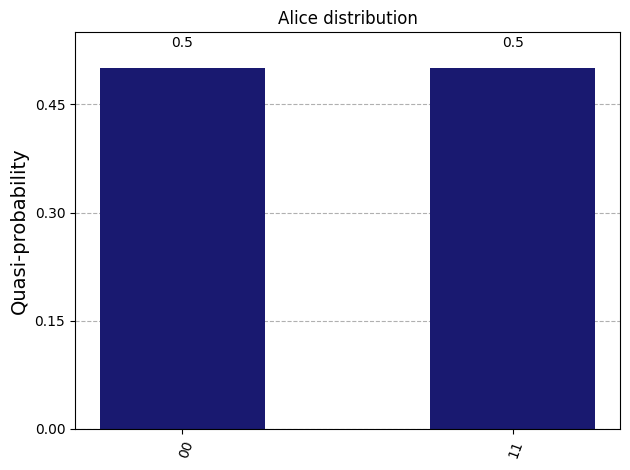

In [64]:
# 状態ベクトル間の等価性をグローバル位相を無視して判定する

final_sv = sv_sim.run(qc).result().get_statevector()
phi_plus_sv = sv_sim.run(phi_plus_prep()).result().get_statevector()
alice_clare_sv = partial_trace(final_sv, [1, 2]).to_statevector()

if alice_clare_sv.equiv(phi_plus_sv):
    print('Congratulations! You made the entanglement swapping works!')
else:
    print('You probably made something wrong!')

display(alice_clare_sv.draw(output='latex'))
display(plot_histogram({k: np.abs(v) ** 2 for k, v in alice_clare_sv.to_dict().items()}, title='Alice distribution', color='midnightblue'))

# Purification

---
Purificationはエラー検知の一種の形です。

量子もつれペア（ベルペア）を生成する過程での不完全性のために発生する外部環境からのノイズが、ベルペアの状態に影響を与えたり、あるいはその状態を変化させてしまうことがあります。生成過程での不完全性が高ければ高いほど、またベルペアをメモリに長時間保存するほど、実際のベルペアの状態は不確かなものになっていきます。

期待通りのベルペアの状態であるという確信を高めるために、Purificationと呼ばれる操作を行うことができます。この操作は、1つ以上のベルペアを消費することで、私たちのベルペアが正しい状態であるかどうかを調べることを可能にします。


Purificationプロトコルを行うことで、そのベルペアが正しい状態である可能性が高いかそうでないかがわかるので、エラー検知プロセスであると言えます。どのエラー（例えば、ビット反転や位相反転など）が起きたかは知ることができません。

## ベルペアにノイズをのせる

前述のとおり、ベルペアは常に完全ではありません。ここでは、ベルペアが80%の確率で $\ket{\Phi_+}$ となり、20%の確率でXエラーがある場合、つまり $\ket{\Psi_+}$ になってしまう状況をシミュレートしてみましょう。

このノートブックでは、20%の確率で自動的にXゲートが制御ビットにかかってしまう `noisyCX()` というゲートが用意されています。


ベルペアを作る時に、この `noisyCX()` を使うことで、ノイジーな（混合状態の）ベルペアの効果をシミュレートすることができます。

In [ ]:
"""How we define noisy CX gate"""
noise_rate = 0.2
def noisyCX(self, a, b):
    self.cx(a, b)
    self.id(b)

QuantumCircuit.noisyCX = noisyCX

p_error = 0.2 # 20% cnot error
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(bit_flip, "id")
noisy_sim = AerSimulator(noise_model=noise_bit_flip)
"""END"""

def sample_faulty_bell_pair():
    counts = {}
    counts[f'$| \\Phi^+ \\rangle $'] = 0
    counts[f'$| \\Psi^+ \\rangle $'] = 0

    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.noisyCX(0, 1)
    qc.measure([0, 1], [0, 1])
    str_counts = noisy_sim.run(qc, shots=10_000).result().get_counts()
    counts[f'$| \\Phi^+ \\rangle $'] = str_counts['00'] + str_counts['11']
    print(str_counts)

    if '01' in str_counts:
        counts[f'$| \\Psi^+ \\rangle $'] += str_counts['01']
    if '10' in str_counts:
        counts[f'$| \\Psi^+ \\rangle $'] += str_counts['10']
    return counts

counts = sample_faulty_bell_pair()
plot_histogram(counts)

### Exercise: noisyCX を使って二つのベルペアを作成しましょう

ベルペアを作成する回路を完成させてください。

**注意**: この回路を作成する関数は確率的で、20%の確率でXゲートを追加します。したがって、結果が変わるかどうかを確認するために何度か実行してみてください！

In [ ]:
bp1 = QuantumRegister(2, 'bell_1')
bp2 = QuantumRegister(2, 'bell_2')
parity_check_creg = ClassicalRegister(2, 'parity_check')
bell_pair_creg = ClassicalRegister(2, 'bellpair_result_creg')


def prepare_two_noisy_bellpair():
    noisy_2_bp_circ = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
    ### NoisyCX を用いて2つのベルペアを作成しよう
    # noisy_2_bp_circ.noisyCX(x, y)




    ### END
    return noisy_2_bp_circ



qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
qc = qc.compose(prepare_two_noisy_bellpair())
# qc.measure([*bp1, *bp2], [*bell_pair_creg, *parity_check_creg])
qc.draw()

### Exercise: Purification回路を作成しましょう

1番目のベルペアのパリティをチェックするために、2番目のベルペアを消費します。

**注意: ここではノイジーではないCXゲートを使います**

In [ ]:
bp1 = QuantumRegister(2, 'bell_1')
bp2 = QuantumRegister(2, 'bell_2')
parity_check_creg = ClassicalRegister(2, 'parity_check')
bell_pair_creg = ClassicalRegister(2, 'bellpair_result_creg')
purification_circ = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)

# purification_circ


## 2つ目のベルペアに対して測定を行う


### END

qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
qc = qc.compose(prepare_two_noisy_bellpair()).compose(purification_circ)
qc.measure([*bp1], [*bell_pair_creg])
qc.draw()

### Exercise: 次のコードブロックを完成させて、Purificationが成功したか確認しましょう

In [ ]:
def is_purification_successful():
    qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
    qc = qc.compose(prepare_two_noisy_bellpair()).compose(purification_circ)
    qc.measure([*bp1], [*bell_pair_creg])

    job = qasm_sim.run(qc, shots=1)
    cnt = job.result().get_counts()
    parity_check_value_str = list(cnt.keys())[0][3:]
    ### Complete the code here

    ## successにはブール値が割り当てられていることを確認せよ (True, False)
    ## というのも、すでにその中の値を使用する測定が行われるからである
    ## parity_check_value_strに格納されている値は以下のいずれかとなっている
    ## '00', '01', '10', '11'
    ## この変数の値を使用する

    success = False

    ### END
    return success, list(cnt.keys())[0][:2] # return success/failure + bp results

### Testing code
if type(is_purification_successful()[0]) == bool:
    print(f'Your code is probably correct!')
else:
    print(f'Your code might not be correct!')

### Exercise: 残るはテストだけ！

1つ目のベルペアに対して測定をするコードを加えたら、以下のコードを実行してみましょう

これは、1000回のpurificationを成功させ、最初のベルペアの読み出しに関する統計情報を集めようとするものです。以前、purificationプロセスを行わなかったとき、ベルペアは80%の確率で正しかったことに注意してください。purificationプロセスによって忠実度(fidelity)が増加する（正しい状態を見る確率が高くなる）ことを確認しましょう。



この出力は、1000個のpurificationされたベルペアを集めるために、実際に何回実行したかを示しています。Purificationは確率的なプロセスであるため、失敗することもあれば成功することもあることがわかります。

In [ ]:
total_run = 0
purified_bp = 0
counts = {}
counts[f'$\Phi+$'] = 0
counts[f'$\Psi+$'] = 0

while total_run < 30000 and purified_bp < 10000:
    succ, res = is_purification_successful()
    total_run +=1

    if not succ:
        continue

    purified_bp += 1
    k = res
    if k == '00' or k == '11':
        counts[f'$\Phi+$'] = counts[f'$\Phi+$'] + 1
    else:
        counts[f'$\Psi+$'] = counts[f'$\Psi+$'] + 1

if total_run >= 30000:
    print('===================================')
    print('You probably did something wrong.\n\n')
    print('===================================')
elif purified_bp == 10000:
    print('Your solution is probably correct.\n\n')
    print('expected success probability is 68%')

print(f'successful purification counts: {purified_bp}')
print(f'    with success probability {purified_bp / total_run} ({purified_bp}/{total_run})')
plot_histogram(counts)

# おめでとうございます！ついに最後まで辿り着きました！

ここまでくれば、量子ネットワーキングの基本的なコンセプトはある程度理解できたはずです。このノートブックが気に入っていただけたなら幸いです。もし何かコメントや提案があれば、ルームやslackで遠慮なく言ってください。どんなフィードバックでも歓迎します。

また、量子ネットワークという分野に興味を持ち、この分野に貢献することを検討していただけると幸いです。私たちにはより多くの人が必要です！